In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

def R_lambda(q_obs, q_mod, lambda_ratio_list, w_lambda, mu_q):
    r"""
    Constructs the full polychromatic point-spread function R(q, q') such that

        I_obs(q) = ∫ R(q, q') I_mod(q') dq'  ≈  (R @ I_mod)(q)

    Parameters
    ----------
    q_obs : (M_obs,) ndarray
        Q-values where the observed intensity I_obs(q) is evaluated.
    q_mod : (M_mod,) ndarray
        Q'-values defining the latent/model intensity I_mod(q').
    lambda_ratio_list : (N,) ndarray
        Ratios ρ_i = λ_i / λ_0 for each wavelength component.
    w_lambda : (N,) ndarray
        Normalized spectral weights (∑ w_lambda = 1).
    mu_q : float
        Gaussian width (in Q-units) controlling the mapping spread from q_mod → q_obs.

        - Small mu_q  → narrow PSF, nearly δ(q−ρq′)
        - Large mu_q  → broad smearing, stronger convolution

    Returns
    -------
    R : (M_obs, M_mod) ndarray
        Discrete kernel approximating R(q, q') including wavelength distribution.

    Notes
    -----
    Implements:
        R(q,q') = Σ_i w_i · [ exp(−(q − ρ_i q')² / (2 μ_q²)) / Z_i(q') ]
    where Z_i(q') ensures ∫ R(q,q') dq = 1 for each q'.

    --------------------------------------------------------------------------
    LaTeX source 
    --------------------------------------------------------------------------
    \begin{equation}
        R(q,q')
        \;=\;
        \sum_{i} w_i \,
        \frac{
            \exp\!\left[-\dfrac{(q - \rho_i q')^2}{2\,\mu_q^2}\right]
        }{
            Z_i(q')
        },
        \qquad
        Z_i(q')
        \;=\;
        \int_{-\infty}^{\infty}
        \exp\!\left[-\dfrac{(q - \rho_i q')^2}{2\,\mu_q^2}\right]
        \mathrm{d}q.
        \label{eq:R_q_def}
    \end{equation}
    --------------------------------------------------------------------------
    """
    q_obs = np.asarray(q_obs)
    q_mod = np.asarray(q_mod)
    lambda_ratio_list = np.asarray(lambda_ratio_list)
    w_lambda = np.asarray(w_lambda)

    M_obs, M_mod = q_obs.size, q_mod.size
    R = np.zeros((M_obs, M_mod), dtype=float)

    # --- Implements: R(q, q') = Σ_i w_i * exp[-(q - ρ_i q')² / (2 μ_q²)] / Z_i(q') ---
    for rho, w_i in zip(lambda_ratio_list, w_lambda):
        q_center = rho * q_mod[None, :]           # Shift q' → ρ_i q'
        diff = q_obs[:, None] - q_center          # (M_obs, M_mod)
        phi = np.exp(-0.5 * (diff / mu_q) ** 2)

        # Normalize over q_obs for each q' (column-wise)
        Z_i = phi.sum(axis=0, keepdims=True)
        Z_i[Z_i == 0] = 1.0
        phi /= Z_i

        # Weighted sum over wavelength components
        R += w_i * phi

    return R

import numpy as np

def R_slit(Qx_obs, Q_mod, sigma_y, mu_Q=0.0):
    r"""
    Constructs the slit-averaged point-spread function R_slit(Q_x, Q')
    corresponding to the vertical slit integration

        I_exp(Q_x) = (1 / (2 σ_y)) ∫_{-σ_y}^{σ_y} I( sqrt(Q_x^2 + Q_y^2) ) dQ_y
                   = ∫ R_slit(Q_x, Q') I(Q') dQ'.

    Parameters
    ----------
    Qx_obs : (M_obs,) ndarray
        Q_x values at which the slit-averaged intensity I_exp(Q_x) is evaluated.
        We assume Qx_obs > 0 as in typical USANS measurements.
    Q_mod : (M_mod,) ndarray
        Radial Q' grid on which the intrinsic 1D intensity I(Q') is defined.
    sigma_y : float
        Half-width of the vertical slit resolution (σ_y in Q_y units).    
    mu_Q : float, optional

    Returns
    -------
    R : (M_obs, M_mod) ndarray
        Discrete kernel matrix approximating R_slit(Q_x, Q') such that
        I_exp ≈ R @ I_mod.

    Notes
    -----
    Implements the analytical PSF

        R_slit(Q_x, Q')
        =
        { (1/σ_y) · Q' / sqrt(Q'^2 − Q_x^2),
          if Q_x ≤ Q' ≤ sqrt(Q_x^2 + σ_y^2);
          0, otherwise }.

    --------------------------------------------------------------------------
    LaTeX source
    --------------------------------------------------------------------------
    \begin{equation}
      I_{\mathrm{exp}}(Q_x)
      \;=\;
      \int_0^{\infty}
      R_{\mathrm{slit}}(Q_x, Q')\, I(Q')\, \mathrm{d}Q',
    \end{equation}
    with the slit point-spread function
    \begin{equation}
      R_{\mathrm{slit}}(Q_x, Q')
      \;=\;
      \begin{cases}
      \dfrac{1}{\sigma_y}\,
      \dfrac{Q'}{\sqrt{Q'^2 - Q_x^2}},
      &
      Q_x \le Q' \le \sqrt{Q_x^2 + \sigma_y^2},
      \\[1.2ex]
      0, & \text{otherwise},
      \end{cases}
      \label{eq:R_slit_def}
    \end{equation}
    \noindent
    which satisfies
    $\int_0^{\infty} R_{\mathrm{slit}}(Q_x, Q')\, \mathrm{d}Q' = 1$ for each $Q_x$.
    --------------------------------------------------------------------------
    """
    Qx_obs = np.asarray(Qx_obs, dtype=float)
    Q_mod = np.asarray(Q_mod, dtype=float)
    R = np.zeros((len(Qx_obs), len(Q_mod)))

    for j, Qx in enumerate(Qx_obs):
        Q_min, Q_max = Qx, np.sqrt(Qx**2 + sigma_y**2)
        mask = (Q_mod >= Q_min) & (Q_mod <= Q_max)
        if not np.any(mask):
            continue
        Qp = Q_mod[mask]
        denom = np.sqrt(np.maximum(Qp**2 - Qx**2, 0))
        R_base = (1.0 / sigma_y) * (Qp / denom)

        if mu_Q > 0:
            # Gaussian interpolation in Q'-space
            for k, Qp_k in enumerate(Qp):
                weight = np.exp(-0.5 * ((Qp - Qp_k) / mu_Q) ** 2)
                weight /= np.sum(weight)
                R[j, mask][k] = np.sum(weight * R_base)
        else:
            R[j, mask] = R_base

    # normalize per column to preserve integral ≈ 1
    R /= np.trapz(R, Q_mod, axis=1, initial=0)[:, None]
    return R

import numpy as np

def R_pinhole(Qx_obs, Q_mod, sigma_Q, mu_Q=0.0, n_Qx_prime=201):
    r"""
    Construct the pinhole point-spread function R_pinhole(Q_x, Q') as a
    weighted superposition of slit PSFs:

        R_pinhole(Q_x,Q')
        = (1 / (π σ_Q^2))
          ∫_{Q_x-σ_Q}^{Q_x+σ_Q} dQ_x' σ_y(Q_x')
          R_slit(Q_x', Q'; σ_y(Q_x')),

    with σ_y(Q_x') = sqrt(σ_Q^2 - (Q_x' - Q_x)^2).

    Parameters
    ----------
    Qx_obs : (M_obs,) ndarray
        Q_x values where the smeared intensity I_exp(Q_x) is evaluated.
        (Assumed Qx_obs > 0 for typical SANS/USANS configurations.)
    Q_mod : (M_mod,) ndarray
        Radial grid Q' on which the intrinsic intensity I(Q') is defined.
    sigma_Q : float
        Radius of the circular instrumental resolution (pinhole aperture)
        in Q-space.
    mu_Q : float, optional
        Standard deviation for Gaussian interpolation in Q'-space.
    n_Qx_prime : int, optional
        Number of quadrature points used to resolve the integral over Q_x'.
        Larger values improve accuracy at the cost of speed.

    Returns
    -------
    R : (M_obs, M_mod) ndarray
        Discrete kernel approximating R_pinhole(Q_x, Q') such that
        I_exp ≈ R @ I_mod.

    Notes
    -----
    This implements Eq. (R_pinhole_from_slit) in your text:

        R_pinhole(Q_x,Q')
        = 1/(πσ_Q^2)
          ∫_{Q_x-σ_Q}^{Q_x+σ_Q} dQ_x' σ_y(Q_x')
          R_slit(Q_x', Q'; σ_y(Q_x')),

    with the slit kernel

        R_slit(Q_x', Q'; σ_y)
        =
        { (1/σ_y) · Q' / sqrt(Q'^2 − Q_x'^2),
          if Q_x' ≤ Q' ≤ sqrt(Q_x'^2 + σ_y^2);
          0, otherwise }.

    ----------------------------------------------------------------------
    LaTeX source block 
    ----------------------------------------------------------------------
    \begin{equation}
      R_{\mathrm{pinhole}}(Q_x,Q')
      = \frac{1}{\pi\sigma_Q^2}
        \int_{Q_x-\sigma_Q}^{Q_x+\sigma_Q}
        \!\!\mathrm{d}Q_x'\;
        \sigma_y(Q_x')\,
        R_{\mathrm{slit}}\!\big(Q_x',Q'\,;\,\sigma_y(Q_x')\big),
      \label{eq:R_pinhole_from_slit}
    \end{equation}
    with
    \(
      \sigma_y(Q_x') = \sqrt{\sigma_Q^2 - (Q_x' - Q_x)^2}
    \)
    and $R_{\mathrm{slit}}$ given by Eq.~\eqref{eq:R_slit_def}.
    ----------------------------------------------------------------------
    """
    Qx_obs = np.asarray(Qx_obs, dtype=float)
    Q_mod = np.asarray(Q_mod, dtype=float)
    R = np.zeros((len(Qx_obs), len(Q_mod)))

    for j, Qx in enumerate(Qx_obs):
        Qx_prime = np.linspace(Qx - sigma_Q, Qx + sigma_Q, n_Qx_prime)
        dQx = Qx_prime[1] - Qx_prime[0]
        for Qxp in Qx_prime:
            delta = sigma_Q**2 - (Qxp - Qx)**2
            if delta <= 0:
                continue
            sigma_y = np.sqrt(delta)
            Qx_eff = abs(Qxp)
            R_slit_part = R_slit([Qx_eff], Q_mod, sigma_y, mu_Q=mu_Q)[0]
            R[j, :] += (sigma_y / (np.pi * sigma_Q**2)) * R_slit_part * dQx

    return R


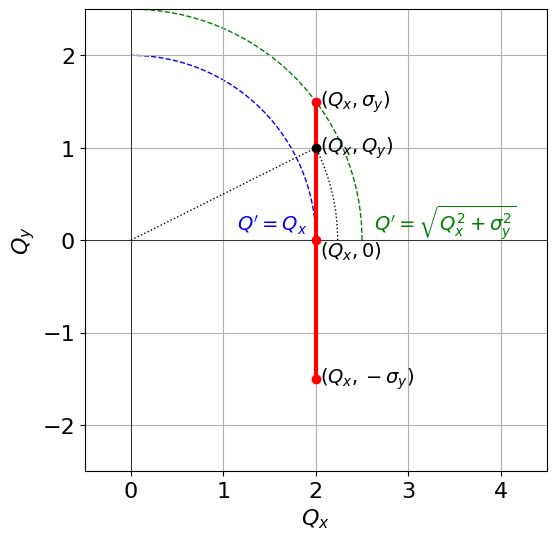

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Set parameters for the schematic
Qx_val = 2.0
sigma_y_val = 1.5
Qmax_val = np.sqrt(Qx_val**2 + sigma_y_val**2)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Draw axes
ax.axhline(0, color='black', lw=0.5)
ax.axvline(0, color='black', lw=0.5)

# Draw the integration slit
ax.plot([Qx_val, Qx_val], [-sigma_y_val, sigma_y_val], 'r-', lw=3, label='Slit Integration Path')

# Plot points
ax.plot([Qx_val], [0], 'ro')
ax.plot([Qx_val], [sigma_y_val], 'ro')
ax.plot([Qx_val], [-sigma_y_val], 'ro')

# Add labels for points
ax.text(Qx_val + 0.05, -0.12, '$(Q_x, 0)$', ha='left', va='center', fontsize=14)
ax.text(Qx_val + 0.05, sigma_y_val, '$(Q_x, \sigma_y)$', ha='left', va='center', fontsize=14)
ax.text(Qx_val + 0.05, -sigma_y_val, '$(Q_x, -\sigma_y)$', ha='left', va='center', fontsize=14)

# Draw arcs to represent Q'
# Arc for Q' = Q_x
arc_min = patches.Arc((0, 0), 2 * Qx_val, 2 * Qx_val, theta1=0, theta2=90, color='blue', ls='--', label="$Q' = Q_x$ (min radius)")
ax.add_patch(arc_min)
ax.text(Qx_val / 1.75, 0.1, "$Q' = Q_x$", color='blue', fontsize=14)

# Arc for Q' = sqrt(Q_x^2 + sigma_y^2)
arc_max = patches.Arc((0, 0), 2 * Qmax_val, 2 * Qmax_val, theta1=0, theta2=90, color='green', ls='--', label="$Q' = \sqrt{Q_x^2 + \sigma_y^2}$ (max radius)")
ax.add_patch(arc_max)
ax.text(Qmax_val * 1.05, 0.1, "$Q' = \sqrt{Q_x^2 + \sigma_y^2}$", color='green', fontsize=14)

# Draw a point (Q_x, Q_y) on the slit and the corresponding arc
Qy_sample = 1.0
Q_sample = np.sqrt(Qx_val**2 + Qy_sample**2)
ax.plot([Qx_val], [Qy_sample], 'ko')
ax.text(Qx_val + 0.05, Qy_sample, '$(Q_x, Q_y)$', ha='left', va='center', fontsize=14)
arc_sample = patches.Arc((0, 0), 2 * Q_sample, 2 * Q_sample, theta1=0, theta2=np.degrees(np.arctan(Qy_sample/Qx_val)), color='black', ls=':', lw=1, label="$Q' = \sqrt{Q_x^2 + Q_y^2}$")
ax.add_patch(arc_sample)
ax.plot([0, Qx_val], [0, Qy_sample], 'k:', lw=1)

# Set labels and title
ax.set_xlabel('$Q_x$', fontsize=16)
ax.set_ylabel('$Q_y$', fontsize=16)

# Set limits and aspect ratio
ax.set_xlim(-0.5, Qmax_val + 2)
ax.set_ylim(-sigma_y_val - 1, sigma_y_val + 1)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(axis='both', which='major', labelsize=16)
# ax.legend()
ax.grid(True)

